# Compare Cost Function Values of different Methods 
----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import yaml

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Running on {}!'.format(device))

Running on cpu!


In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [4]:
methods = ['broyden_method']

### Node Classification Datasets

In [ ]:
datasets_node = ['cora','reddit-self-loop','ppi']

In [ ]:
H_node = []
for dataset in datasets_node:
    for method in methods:
        path = '../src/run/H_' + dataset + '_' + method + '.pkl'
        model_file = os.path.join(os.getcwd(), path)
        h = torch.load(model_file,map_location=device).numpy()
        H_node.append(h)

### Graph Classification Dataset

In [5]:
datasets_graph = ['proteins']

In [6]:
# read data from file
H_graph = []
for dataset in datasets_graph:
    for method in methods:
        path = '../src/outputs/H_tu_' + dataset + '_' + method + '.pkl'
        file = os.path.join(os.getcwd(), path)
        h = torch.load(file,map_location=device)
        H_graph.append(h)

cost_func_graph = []
for dataset in datasets_graph:
    for method in methods:
        path = '../src/outputs/cost_func_tu_' + dataset + '_' + method + '.pkl'
        file = os.path.join(os.getcwd(), path)
        cf = torch.load(file,map_location=device)
        cost_func_graph.append(cf)
        
indices_graph = []
for dataset in datasets_graph:
    for method in methods:
        path = '../src/outputs/indices_tu_' + dataset + '_' + method + '.pkl'
        file = os.path.join(os.getcwd(), path)
        ind = torch.load(file,map_location=device)
        indices_graph.append(ind)

********** proteins **********
All methods successfully finished!


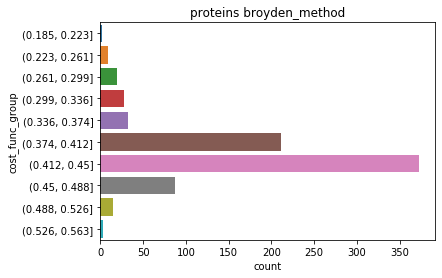

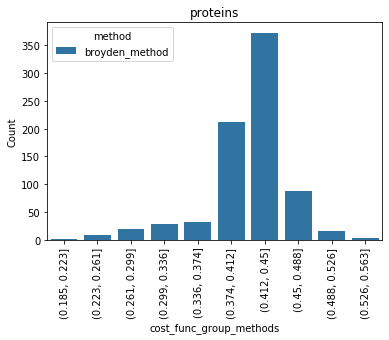

In [7]:
# cost function value visualization
for i in np.arange(len(cost_func_graph)):
    if i % len(methods) == 0:
        dataset_num = int(i/len(methods))
        dataset_name = datasets_graph[dataset_num]
        print('********** '+dataset_name+' **********')
        
        df_list = []
        for j in np.arange(len(methods)):
            df = pd.DataFrame({'graph_id': np.arange(len(cost_func_graph[i+j])),
                                'method': methods[j],
                                'min_cost_func': cost_func_graph[i+j]})
            df_list.append(df)
        
        # check if result is saved before return to main
        config_path = '../src/configs/tu_' + dataset_name + '.yaml'
        config_file = os.path.join(os.getcwd(), config_path)
        with open(config_file, 'r') as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        training_set_len = int(config['dataset_len'] * config['train_ratio'])
        length = training_set_len
        for j in np.arange(len(methods)):
            if len(H_graph[i+j])<training_set_len:
                print("{}:Intermediate result of {}! Result for {} graphs available.".format(dataset_name,methods[j],len(H_graph[i+j])))
                df_list[j] = df_list[j][:len(H_graph[i+j])]
                length = min(length,len(H_graph[i+j]))
        if length==training_set_len:
            print("All methods successfully finished!")
        
        # plot for each method
        for method_num,df in zip(np.arange(len(methods)),df_list):
            df['cost_func_group'] = pd.cut(df['min_cost_func'],10)
        
            plt.title(dataset_name + ' ' + methods[method_num])
            sns.countplot(y = 'cost_func_group', data = df)
            plt.show()
        
        # plot all methods together
        df_methods = pd.concat(df_list, axis=0, ignore_index=True)
        df_methods['cost_func_group_methods'] = pd.cut(df_methods['min_cost_func'],10)
        group_df = df_methods.groupby(['method','cost_func_group_methods']).size().reset_index(name='Count')
         
        plt.title(dataset_name)
        g = sns.barplot(x = 'cost_func_group_methods', y = 'Count', hue = 'method', data = group_df)
        for item in g.get_xticklabels():
            item.set_rotation(90)
        plt.show()

In [8]:
num_found_array = np.zeros([len(methods),len(datasets_graph)])
for i in np.arange(len(indices_graph)):
    if i % len(methods) == 0:
        dataset_num = int(i/len(methods))
        dataset_name = datasets_graph[dataset_num]
        
        for j in np.arange(len(methods)):
            num_found_array[j,dataset_num] = indices_graph[i+j][indices_graph[i+j] == True].shape[0]

num_found_df = pd.DataFrame(num_found_array,index=methods,columns=datasets_graph)
num_found_df

,proteins
broyden_method,0.0
